In [1]:
# importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
import cv2

# importing cosine similarity to find similarity between operations
from sklearn.metrics.pairwise import cosine_similarity

from pandas.core.common import flatten

# importing torch
import torch
import torch.nn as nn

# importing cv models
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable

# import image
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [2]:
# importing metadata
#!ls
df = pd.read_csv('./archive/styles.csv', error_bad_lines=False, warn_bad_lines=False)
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch


In [3]:
# set style
plt.style.use('ggplot')

<Axes: >

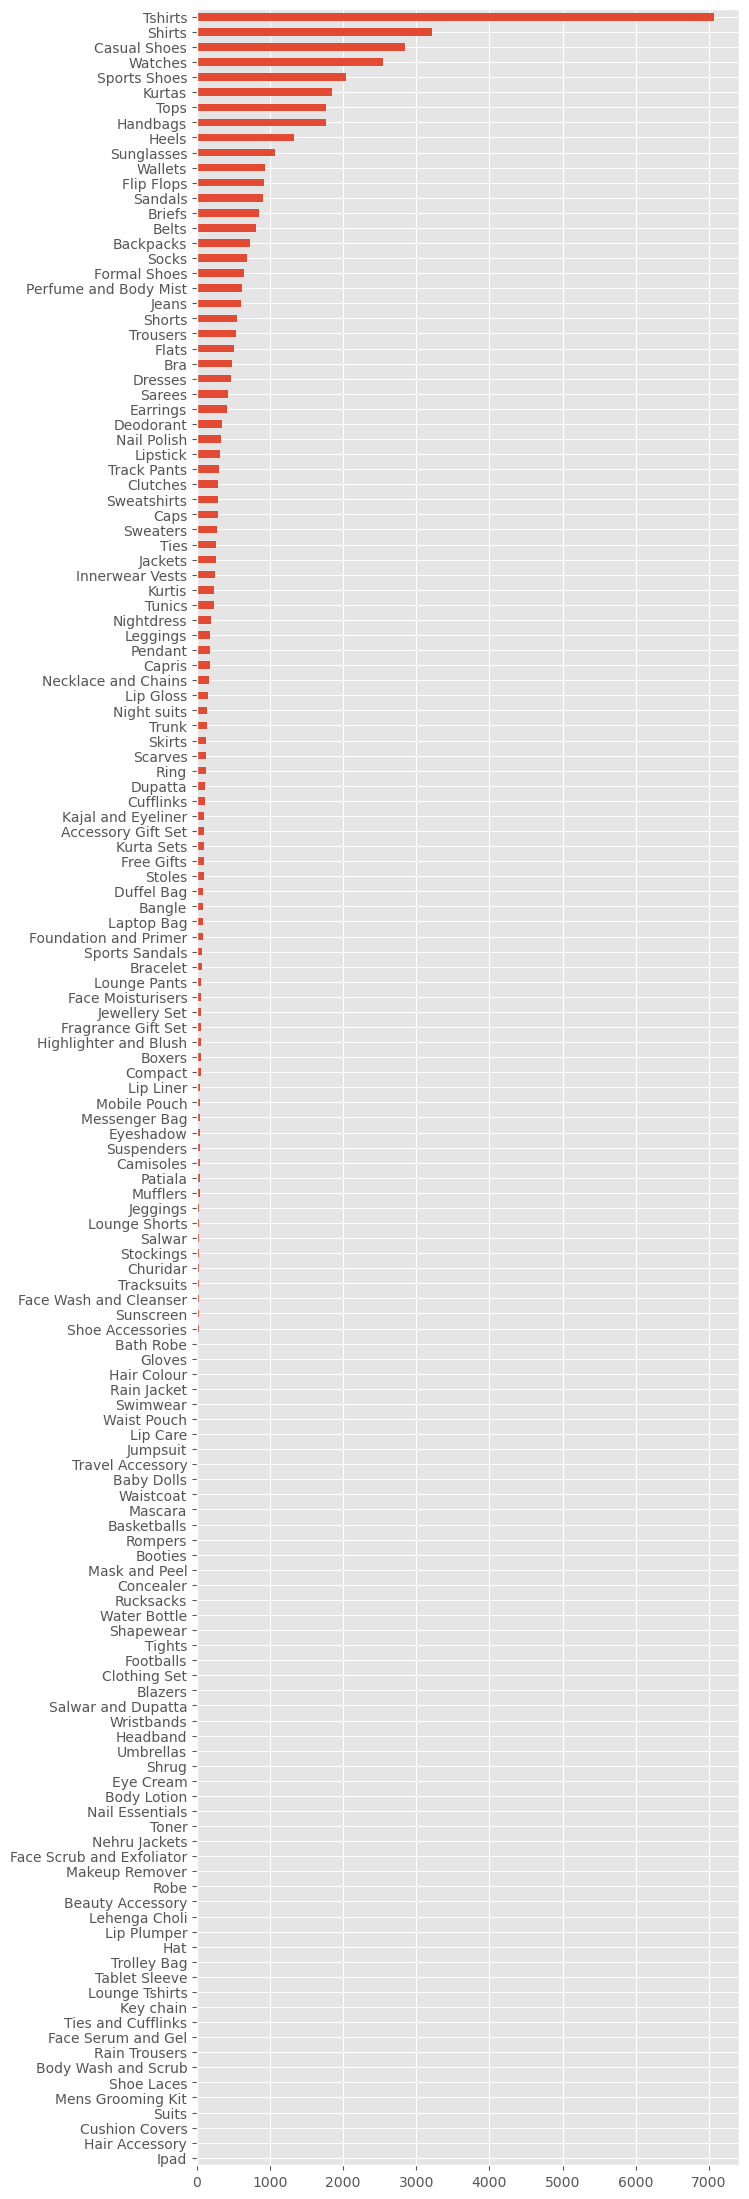

In [4]:
# plotting the class distribution using the articleType column
plt.figure(figsize=(7,28))
df.articleType.value_counts().sort_values().plot(kind='barh')

In [5]:
# create the column to store image location ids
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)

# resetting the index
df = df.reset_index(drop=True)
df.head()


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg


In [6]:
# function to obtain image path
def image_location(img):
    return './archive/images/' + img

# function to load image
def import_img(image):
    image_rgb = cv2.imread(image_location(image))
    print(image)
    return image_rgb

# function to show images based on row and column numbers
def show_images(images, rows=1, cols=1, figsize=(12,12)):
    # define fig
    fig, axes = plt.subplots(ncols=cols,nrows=rows, figsize=figsize)
    
    # loop for images
    for index, name in enumerate(images):
        axes.ravel()[index].imshow(cv2.cvtColor(images[name],cv2.COLOR_BGR2RGB))
        axes.ravel()[index].set_title(name)
        axes.ravel()[index].set_axis_off()
    
    # plot
    plt.tight_layout()


6895.jpg
6446.jpg
11719.jpg
25642.jpg
11210.jpg
49462.jpg


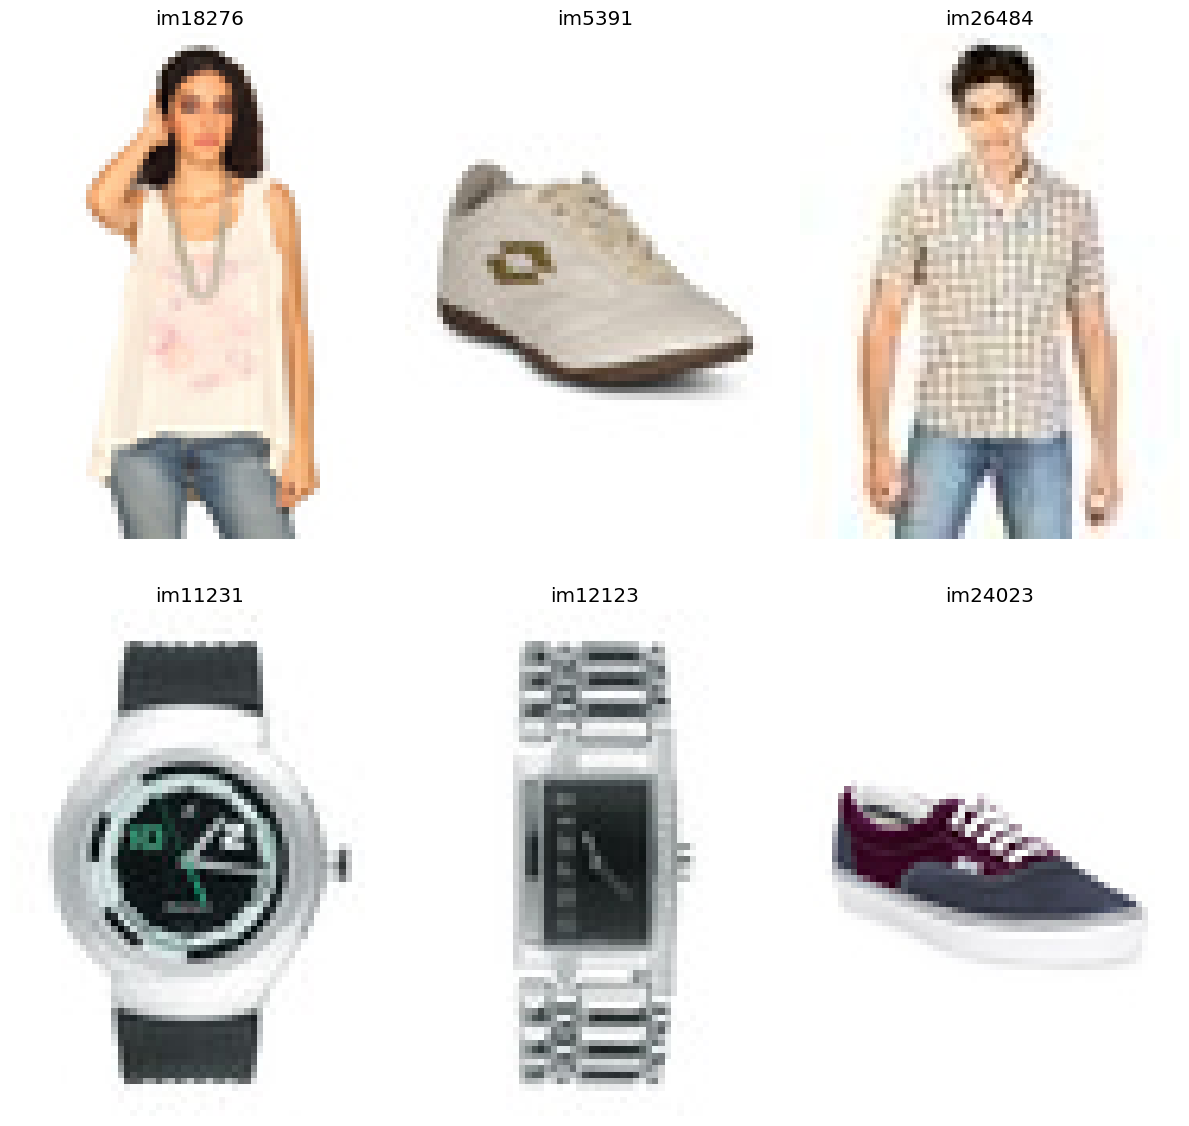

In [7]:
# generation of a dictionary of {index, image }
figures = {'im' + str(i): import_img(row.image) for i, row in df.sample(6).iterrows()}

# plotting the images in a figure, with 2 rows and 3 columns
show_images(figures, 2,3)

In [8]:
# Feature Engineering
# Defining the input shape
width, height = 224, 224
# loading the pretrained model
resnetmodel = models.resnet18(pretrained=True)

In [9]:
# selecting the layer
layer = resnetmodel._modules.get('avgpool')
# evaluation
resnetmodel.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
# scaling the data
s_data = transforms.Resize((224,224))

# normalizing
standardize = transforms.Normalize(mean=[0.7,0.6,0.3], std=[0.2, 0.3, 0.1])

# converting to tensor
convert_tensor = transforms.ToTensor()

# creating the missing image object
missing_img = []

# function to get embeddings
def vector_extraction(resnetmodel, image_id):
    try: 
        img = Image.open(image_location(image_id)).convert('RGB')
        t_img = Variable(standardize(convert_tensor(s_data(img))).unsqueeze(0))
        
        embeddings = torch.zeros(512)
        
        def select_d(m, i, o):
            embeddings.copy_(o.data.reshape(o.data.size(1)))
        
        hlayer = layer.register_forward_hook(select_d)
        
        resnetmodel(t_img)
        
        hlayer.remove()
        
        emb = embeddings
        
        return embeddings
    
    # if file not found
    except FileNotFoundError:
        # store the index of such entries in missing_img list and drop them later
        
        missed_img = df[df['image']==image_id].index
        print(missed_img)
        missing_img.append(missed_img)
        

15970.jpg
(80, 60, 3)
tensor([3.6048e-01, 9.8693e-01, 2.3240e-01, 1.6690e+00, 3.1513e-01, 7.5393e-01,
        4.3338e-01, 1.2030e-01, 1.6725e+00, 1.5513e+00, 1.8964e-01, 8.2588e-01,
        5.1050e-01, 8.5980e-02, 9.8755e-03, 1.3050e-01, 9.9360e-01, 1.2246e-01,
        1.6302e-01, 1.8046e+00, 9.4435e-01, 1.3779e+00, 2.1519e+00, 4.8767e-01,
        1.2682e-01, 3.1091e-01, 8.3039e-01, 3.0100e+00, 7.7897e-02, 4.9649e-01,
        8.5514e-01, 3.0350e-01, 3.5636e-01, 2.3899e+00, 9.0330e-01, 1.1726e+00,
        4.6758e-01, 4.2146e-01, 8.5769e-01, 5.5814e-01, 5.1486e-01, 2.2462e-01,
        1.3500e-01, 1.5317e+00, 2.5450e+00, 2.7813e-01, 1.1332e-01, 2.9904e-01,
        2.4004e+00, 5.8370e-01, 1.5316e+00, 1.1459e+00, 6.3753e-01, 5.5374e-01,
        6.6281e-01, 6.9787e-01, 1.4696e-01, 3.6548e+00, 9.4378e-01, 1.4293e+00,
        2.0492e-01, 5.9428e-01, 5.4688e-01, 5.0279e-01, 2.0592e-01, 5.0718e-02,
        1.2491e+00, 3.5593e-01, 1.1399e+00, 1.3888e+00, 5.4131e-02, 1.7949e+00,
        2.5154e-01

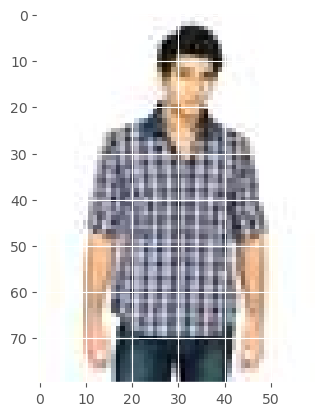

In [11]:
# testing if our vector_extraction function works well on sample image

sample_embedding_0 = vector_extraction(resnetmodel, df.iloc[0].image)

# plotting the sample image and its embeddings
img_array = import_img(df.iloc[0].image)

plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(sample_embedding_0)

12367.jpg
(80, 60, 3)
tensor([2.2214e-01, 4.8201e-01, 1.4577e+00, 2.0319e+00, 7.2153e-02, 1.1472e+00,
        3.7525e-01, 1.2374e-01, 1.2103e+00, 1.6589e+00, 4.6383e-01, 1.1207e+00,
        1.8761e-01, 1.6882e-01, 7.9731e-02, 9.6742e-01, 3.4295e-01, 6.1189e-01,
        1.4849e-01, 2.1886e+00, 4.2695e-01, 7.3654e-01, 2.2325e+00, 7.4541e-01,
        3.7189e-01, 2.1022e-01, 2.0852e-01, 3.8510e+00, 0.0000e+00, 7.6034e-01,
        5.2886e-01, 5.1996e-02, 4.3434e-01, 2.9405e+00, 3.0286e+00, 7.1146e-02,
        5.4161e-01, 1.2275e-01, 1.0301e+00, 8.6784e-01, 2.9940e-01, 2.2237e-01,
        2.0470e-01, 5.1393e-01, 8.8564e-01, 1.4416e+00, 4.1729e-01, 1.9291e-01,
        1.4389e+00, 4.5813e-01, 2.1016e+00, 1.2736e+00, 2.7155e-01, 5.5243e-01,
        7.0722e-01, 9.0096e-01, 3.1049e-02, 1.2802e+00, 7.3365e-01, 5.1611e-01,
        2.2345e-01, 1.3885e-01, 1.7405e+00, 1.2096e+00, 5.0332e-01, 7.8591e-01,
        1.8049e+00, 2.8785e-02, 4.2256e-01, 9.1533e-01, 1.3768e+00, 1.5604e+00,
        2.5527e-01

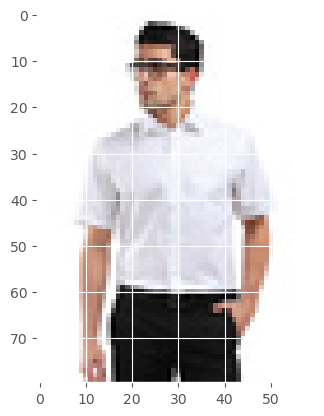

In [12]:
# testing if our vector_extraction function works well on sample image
sample_embedding_1 = vector_extraction(resnetmodel, df.iloc[1000].image)

# plotting the sample image and its embeddings
img_array = import_img(df.iloc[1000].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(sample_embedding_1)

In [13]:
# finding the similarity between the two images
cos_sim = cosine_similarity(sample_embedding_0.unsqueeze(0), sample_embedding_1.unsqueeze(0))
print("\nCosine similarity: {0}\n".format(cos_sim))


Cosine similarity: [[0.86287767]]



In [16]:
%%time
import swifter

# Applying the embeddings on subset of this huge dataset
df_embeddings = df[:5000] # We can apply on entire df, like df_embeddings = df

# looping through the images to get embeddings
map_embeddings = df_embeddings['image'].swifter.apply(lambda img: vector_extraction(resnetmodel, img))

# convert to series
df_embs = map_embeddings.apply(pd.Series)
print(df_embs.shape)
df_embs.head()

Pandas Apply:   0%|          | 0/5000 [00:00<?, ?it/s]

(5000, 512)
CPU times: user 13min 57s, sys: 1min, total: 14min 58s
Wall time: 3min 45s


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.360482,0.986928,0.232401,1.669048,0.315127,0.753928,0.433384,0.120297,1.672540,1.551312,...,0.599805,0.879021,2.274732,0.550262,0.000889,0.135180,1.871304,1.418938,0.000000,0.523688
1,0.754325,0.232688,0.522140,2.608785,0.838683,0.135893,0.427806,0.854116,0.601941,2.225886,...,0.222548,0.424173,0.006582,0.189140,0.000000,0.156890,1.189896,0.405765,0.087880,0.134553
2,0.331700,0.240245,3.068739,2.655946,0.009184,0.013017,3.198415,0.591138,3.220150,4.040012,...,0.303095,3.104079,1.619332,0.973718,0.458845,0.000000,1.401980,0.908382,0.000000,0.000000
3,0.624761,0.258359,0.544933,2.922385,0.353659,0.141806,0.799510,0.617607,0.298829,0.843660,...,0.320797,0.392780,0.261848,0.159667,0.000000,0.005314,0.677280,0.223054,0.063506,0.190919
4,0.452778,0.649997,0.348728,1.654590,0.135157,1.385382,0.481831,0.515382,2.859257,1.028547,...,0.432272,0.875069,1.472379,0.889062,0.074484,0.321774,1.748126,0.052523,0.000000,0.241553


In [126]:
# export the embeddings
df_embs.to_csv('df_embs.csv', index_label=False)

# importing the embeddings
df_embs = pd.read_csv('df_embs.csv', index_col=0)
#df_embs.drop(["Unnamed: 0"],axis=1,inplace=True)
df_embs.dropna(inplace=True)


#exporting as pkl
joblib.dump(df_embs, 'df_embs.pkl', 9)

#importing the pkl
df_embs = joblib.load('df_embs.pkl')
#print(df_embs.shape)

In [136]:
print(df_embs.shape)
df_embs.head(10)

(5000, 512)


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.360482,0.986928,0.232401,1.669048,0.315127,0.753928,0.433384,0.120297,1.672540,1.551312,...,0.599805,0.879021,2.274732,0.550262,0.000889,0.135180,1.871304,1.418938,0.000000,0.523688
1,0.754325,0.232688,0.522140,2.608785,0.838683,0.135893,0.427806,0.854116,0.601941,2.225886,...,0.222548,0.424173,0.006582,0.189140,0.000000,0.156890,1.189896,0.405765,0.087880,0.134553
2,0.331700,0.240245,3.068739,2.655946,0.009184,0.013017,3.198415,0.591138,3.220150,4.040012,...,0.303095,3.104078,1.619332,0.973718,0.458845,0.000000,1.401980,0.908382,0.000000,0.000000
3,0.624761,0.258359,0.544933,2.922385,0.353659,0.141806,0.799510,0.617606,0.298829,0.843660,...,0.320797,0.392780,0.261848,0.159667,0.000000,0.005314,0.677280,0.223054,0.063506,0.190919
4,0.452778,0.649997,0.348728,1.654590,0.135157,1.385382,0.481831,0.515382,2.859257,1.028547,...,0.432272,0.875069,1.472379,0.889062,0.074484,0.321774,1.748126,0.052523,0.000000,0.241553
5,0.031509,0.053469,0.520734,1.373431,0.062546,0.310396,0.088343,0.147121,1.149911,0.464640,...,0.016822,0.681533,0.860543,1.167626,0.001262,0.500059,1.273784,0.186040,0.021895,0.220778
6,0.119024,0.464922,0.318761,1.069523,0.785851,0.892313,0.568528,0.038832,0.926685,1.015384,...,0.139409,0.690943,1.031502,1.593905,0.009768,0.211900,1.129889,0.129220,0.000000,0.528696
7,0.154242,1.149823,0.669076,1.845616,0.120823,0.605358,0.522919,0.817289,1.724077,1.264278,...,0.730912,0.877549,0.889819,1.787443,0.002419,0.171292,1.679521,0.209863,0.000000,0.906786
8,0.237745,0.019731,2.040757,3.082295,0.409697,0.300546,0.016279,0.777454,0.281391,0.094207,...,0.916647,0.134221,0.340123,0.317278,0.000000,0.160073,1.628951,0.610521,0.233358,0.175042
9,1.360298,0.034650,3.898687,3.149777,0.727793,0.470186,1.371638,0.228204,1.184438,2.868842,...,0.362633,1.622014,0.417450,0.386355,0.054235,0.027774,4.184110,1.472263,0.002127,0.805655


In [23]:
# calculating the similarity between images 
cosine_sim = cosine_similarity(df_embs)

# previewing the first 4 rows and 4 columsn similarity just to check the structure of cosine_sim
cosine_sim[:4,:4]


array([[1.        , 0.73909539, 0.61208828, 0.75792275],
       [0.73909539, 1.        , 0.64107064, 0.8698521 ],
       [0.61208828, 0.64107064, 1.        , 0.60898364],
       [0.75792275, 0.8698521 , 0.60898364, 1.        ]])

In [24]:
# storing the index values in a series index_values for recommending
index_values = pd.Series(range(len(df)), index=df.index)
index_values

0            0
1            1
2            2
3            3
4            4
         ...  
44419    44419
44420    44420
44421    44421
44422    44422
44423    44423
Length: 44424, dtype: int64

In [30]:
# define a function that gives recommendations based on the cosine similarity score
def recommend_images(ImId, df, top_n=6):
    # Assigning index of reference into sim_ImId
    sim_ImId = index_values[ImId]
    
    # storing sosine similarity of all other items with item requested by user in sml_scr as a list
    sml_scr = list(enumerate(cosine_sim[sim_ImId]))
    
    # sorting the list of sml_scr
    sml_scr = sorted(sml_scr, key=lambda x: x[1], reverse=True)
    
    # Extracting the top n values from sml_scr
    sml_scr = sml_scr[1:top_n+1]
    
    # ImId_rec will return the index of similar items
    ImId_rec = [i[0] for i in sml_scr]
    
    # ImId_sim will return the value for similarity score
    ImId_sim = [i[1] for i in sml_scr]
    
    return index_values.iloc[ImId_rec].index, ImId_sim

In [31]:
recommend_images(3810, df, top_n = 5)

(Int64Index([3899, 3678, 3967, 4384, 4746], dtype='int64'),
 [0.9999991388781198,
  0.9999989436181682,
  0.9999988839739554,
  0.9999987591914766,
  0.9999987488328783])

In [39]:
# visualizing the recommended images
def Rec_viz_image(input_imageid):
    # Getting reccommendations
    idx_rec, idx_sim = recommend_images(input_imageid, df, top_n=6)
    
    # printing the similarity score
    print(idx_sim)
    
    # plotting the image of item requested by user
    plt.imshow(cv2.cvtColor(import_img(df.iloc[input_imageid].image), cv2.COLOR_BGR2RGB))
    
    # Generating a dictionary of {index, image}
    figures = {'im' + str(i): import_img(row.image) for i, row in df.loc[idx_rec].iterrows()}
    
    # plotting the similar images in a figure, with 2 rows and 3 columns
    show_images(figures, 2, 3)

[0.9999991388781198, 0.9999989436181682, 0.9999988839739554, 0.9999987591914766, 0.9999987488328783, 0.9999984423521331]
14053.jpg
15971.jpg
16394.jpg
14054.jpg
19176.jpg
19185.jpg
22351.jpg


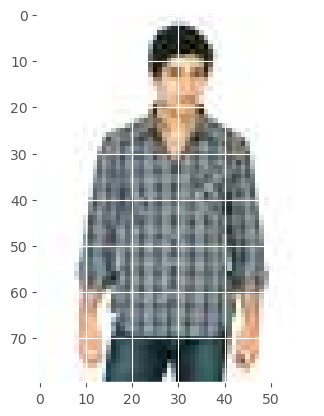

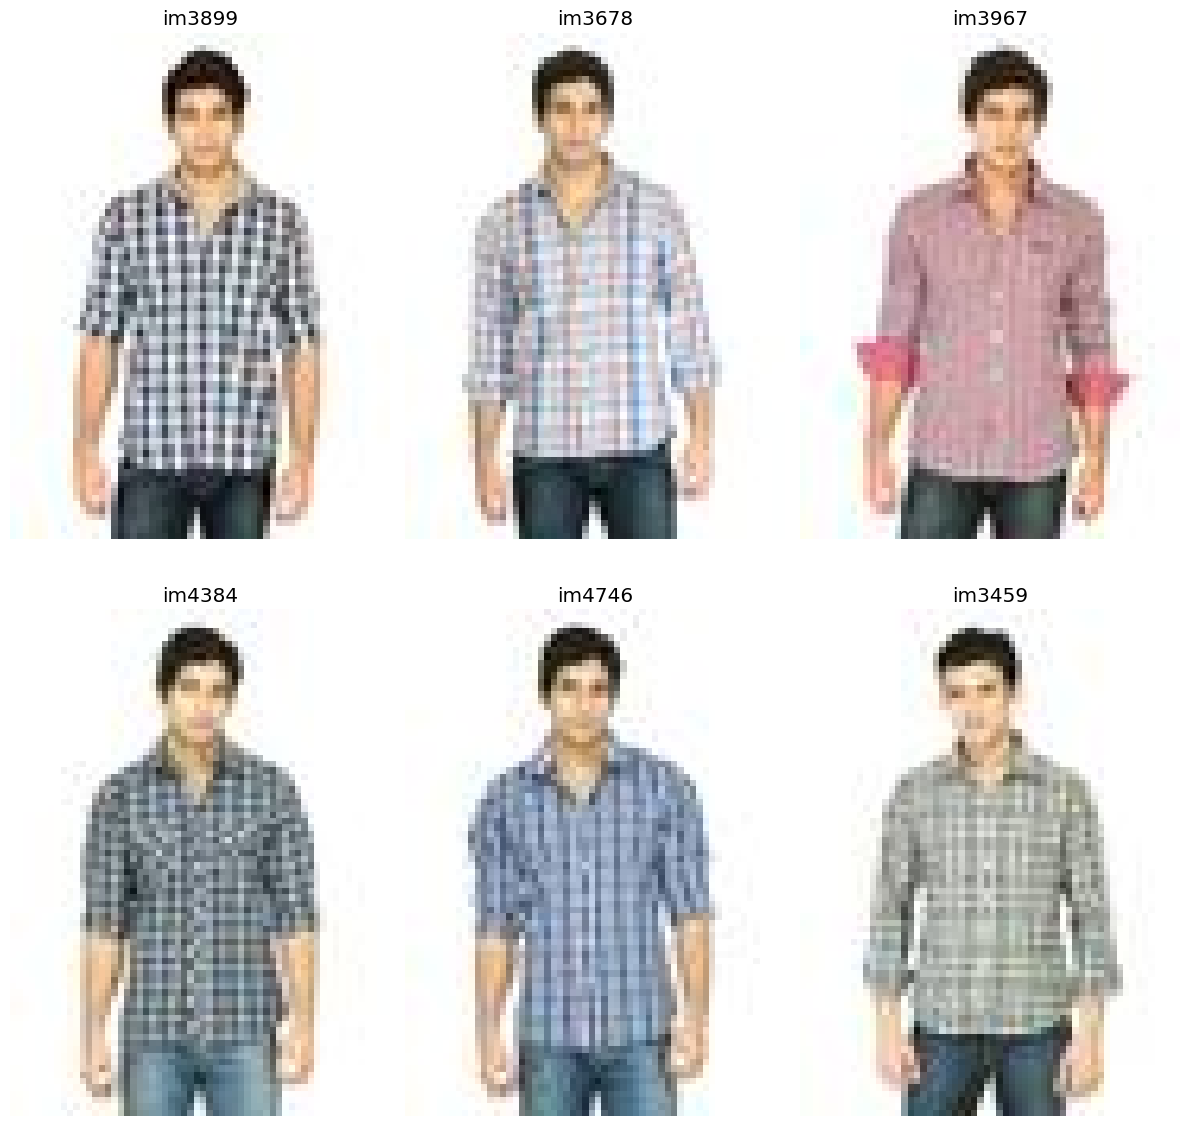

In [40]:
Rec_viz_image(3810)

[0.9999978813336323, 0.9999977036419809, 0.9999975495062678, 0.9999973916785253, 0.9999972107605535, 0.999996988059983]
36351.jpg
50312.jpg
49697.jpg
50315.jpg
36369.jpg
58918.jpg
36350.jpg


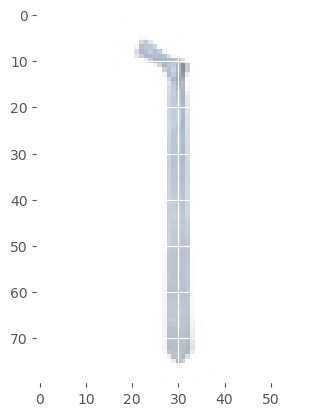

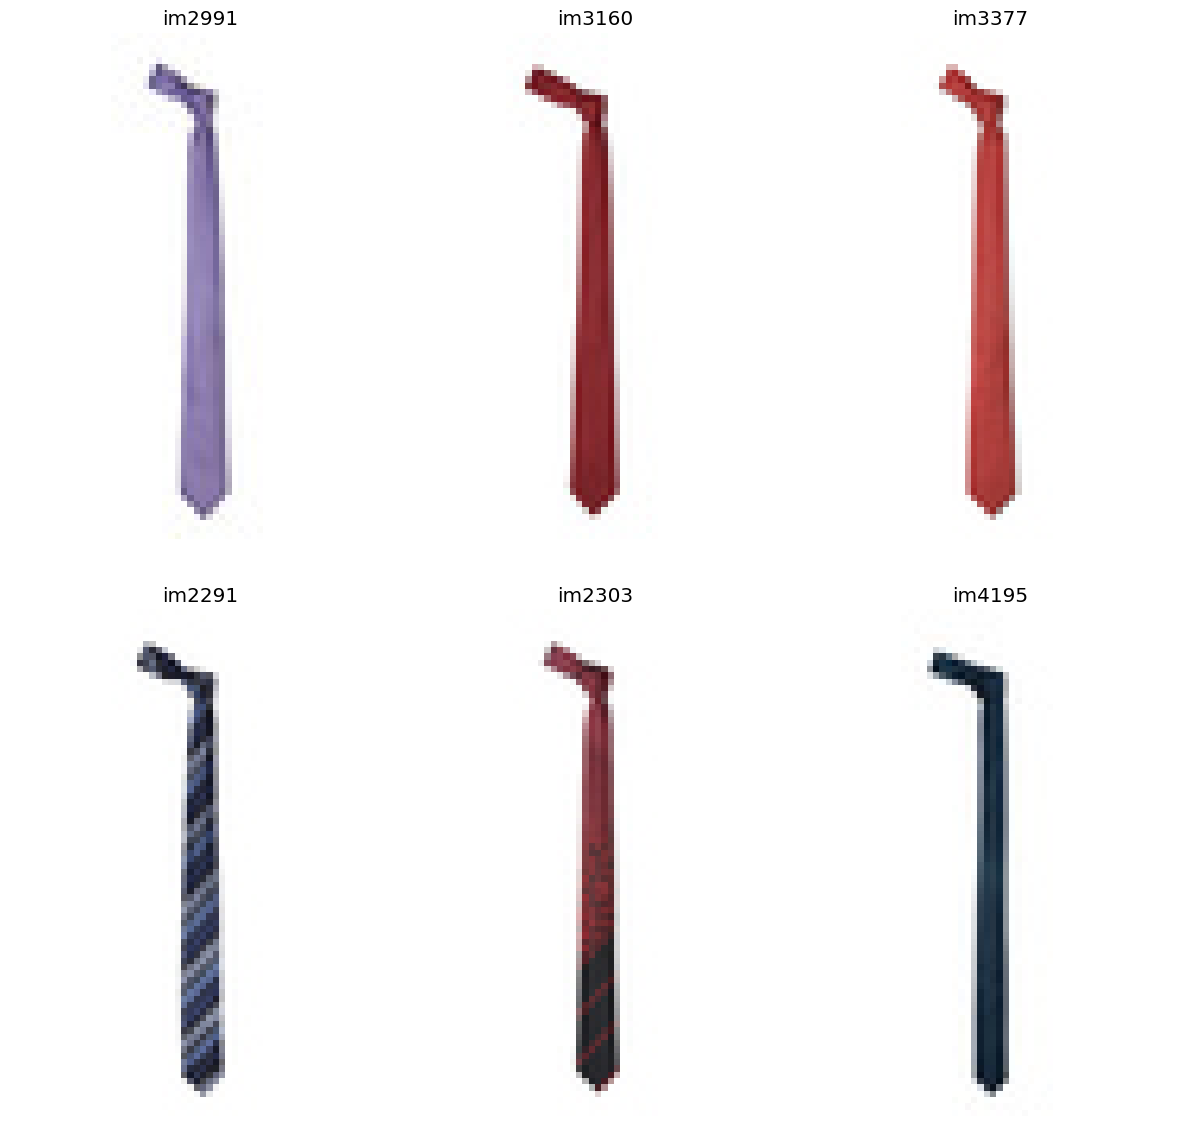

In [42]:
Rec_viz_image(2518)

In [43]:
%ls

 101_ObjectCategories.tar.gz              features.pickle
 archive/                                 filenames.pickle
 archive.zip                              function.html
 assets/                                  image_0001.jpg*
 caltech101/                              image_similarity.py
 df_embs.csv                              index.html
 df_embs.pkl                              README.md
'Fashion Similarity Image Search.ipynb'  'Similarity Search.ipynb'
'Feature Extraction.ipynb'                style/


In [167]:
# Taking image input from users and recommending similar products
def recm_user_input(image_id):
    # loading the image and reshaping it
    img = Image.open(image_id).convert('RGB')
    
    t_img = Variable(standardize(convert_tensor(s_data(img))).unsqueeze(0))
    
    embeddings = torch.zeros(512)
    
    def select_d(m, i, o):
        embeddings.copy_(o.data.reshape(o.data.size(1)))
        
    #print(embeddings.shape)
    
    hlayer = layer.register_forward_hook(select_d)
    
    resnetmodel(t_img)
    
    hlayer.remove()
    emb= embeddings
    #print(emb.shape)
    
    # calculating cosine similarity
    #print(df_embs.shape)
    cs = cosine_similarity(emb.unsqueeze(0), df_embs)
    cs_list = list(flatten(cs))
    cs_df = pd.DataFrame(cs_list,columns=['Score'])
    cs_df = cs_df.sort_values(by=['Score'], ascending=False)

    # printing Cosine similarity
    print(cs_df['Score'][:10])

    # Extracting the index of the top 10 similar items/images
    top10 = cs_df[:10].index
    top10 = list(flatten(top10))
    images_list = []

    for i in top10:
        image_id = df[df.index==i]['image']
        images_list.append(image_id)
        #print(images_list)

    images_list = list(flatten(images_list))
    #print(images_list)

    # plotting the image of item requested by user
    #img_print = Image.open(image_id).convert('RGB')
    #print(img_print)
    plt.imshow(img)
    
    # generating a dictionary {index, image}
    figures = {'im' + str(i): Image.open('./archive/images/' + i) for i in images_list}
    
    # plotting the similar images in a figure, with 2 rows and 3 columns
    fig, axes = plt.subplots(2,5,figsize=(8,8))
    for index, name in enumerate(figures):
        axes.ravel()[index].imshow(figures[name])
        axes.ravel()[index].set_title(name)
        axes.ravel()[index].set_axis_off()
    plt.tight_layout()

1333    0.861825
3688    0.844468
2900    0.844351
1939    0.839999
1451    0.833859
3268    0.832910
1299    0.823948
516     0.823724
4528    0.823425
3725    0.820266
Name: Score, dtype: float64


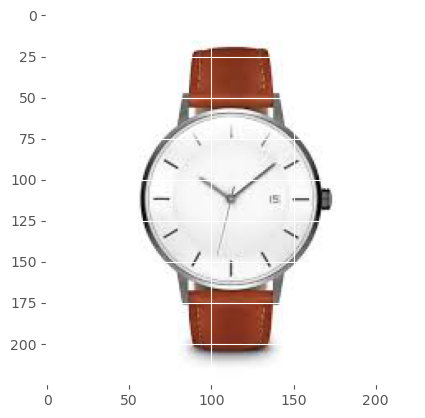

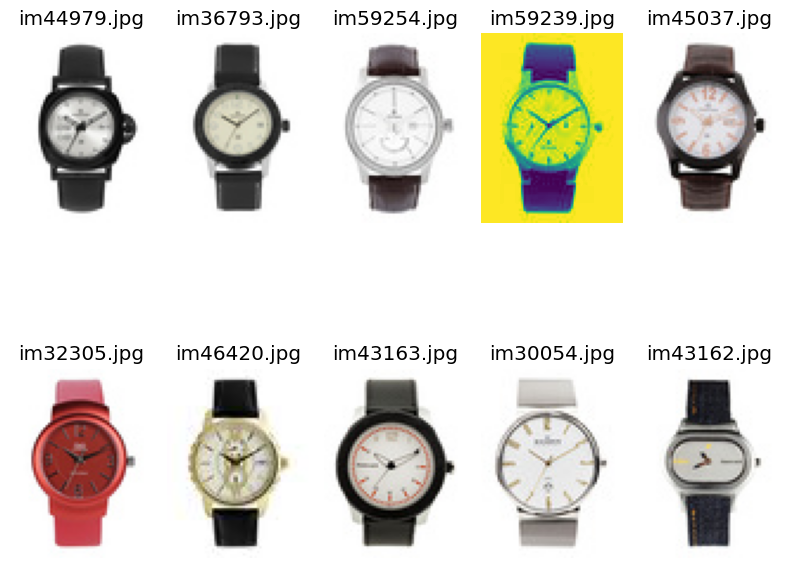

In [168]:
recm_user_input('test_watch.jpeg')